In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
from natsort import natsorted, ns
import scipy.io
import cv2
import dlib
from PIL import Image

## Useful Functions

In [2]:
def resize_image(image, new_size=(128, 128)):
    """resize a numpy image using PIL image with antialiasing"""
    img_resize = Image.fromarray(image)
    img_resize = img_resize.resize(new_size, Image.ANTIALIAS)
    img_resize_np = np.array(img_resize)
    return img_resize_np

In [3]:
def optimal_quantization(t2d_data, print_mode = False):
    """scale values in thermal image to cover most suitable range"""
    t2d_data_cp = copy.deepcopy(t2d_data)  
    
    vector_data= np.reshape(t2d_data_cp, t2d_data_cp.shape[0]*t2d_data_cp.shape[1])
    # select only values above zero when calculating min/max to avoid padding - sm
    vector_data = vector_data[vector_data > 0]
    
    min_T=np.percentile(vector_data, 2.5)  #2.5 percentile point
#     max_T=np.percentile(vector_data, 97.5) #97.5 percentile point
    
    # try a higher max_T - sm
    max_T=np.percentile(vector_data, 100) #99.5 percentile point
#     max_T = 36

    t2d_data_cp[np.where(t2d_data_cp > max_T)]=max_T
    t2d_data_cp[np.where(t2d_data_cp < min_T)]=min_T

    opt_T=min_T
    count=0
    while True:
        count+=1
        mean_back=np.mean(t2d_data_cp[np.where(t2d_data_cp <= opt_T)])
        mean_obj=np.mean(t2d_data_cp[np.where(t2d_data_cp > opt_T)])
        if np.abs(opt_T - (mean_back+mean_obj)/2 )<0.005:
            break;
        else:
            opt_T=(mean_back+mean_obj)/2

    min_T=opt_T

    if print_mode:
        print("optimal thermal range is [%f, %f]"%(min_T,max_T))

    t2d_data_cp[np.where(t2d_data_cp < min_T)]=min_T

    quantized_t_img=np.zeros((t2d_data_cp.shape[0],t2d_data_cp.shape[1]), np.uint8)

    for i in range(0, t2d_data_cp.shape[0]):
        for j in range(0, t2d_data_cp.shape[1]):
            quantized_t_img[i,j]=255*((t2d_data_cp[i,j]-min_T)/(max_T-min_T))

    return quantized_t_img 

In [4]:
def thr_rgb_frameplot(p='17', rgb_frame=0, thr_frame=0, oq=True):
    """compare single frames of thermal and rgb"""
    rgb_path = '/Volumes/Ashur DT2/steven/P' + p + '/RGB/00000/00000_' + str(rgb_frame).zfill(5) + '.jpg'
    thr_path = '/Volumes/Ashur DT2/steven/P' + p + '/FLIR_HiRes/npy/frm_' + str(thr_frame) + '.npy'
    fig, ax = plt.subplots(ncols=2, figsize=(16, 12))
    rgb_img = dlib.load_rgb_image(rgb_path)

    thr_img = np.load(thr_path)
    thr_img_oq = optimal_quantization(thr_img)
    if oq == True:
#         ax[0].imshow(thr_img_oq, cmap=plt.get_cmap('hot'))
#         ax[0].imshow(thr_img_oq, cmap=plt.get_cmap('gray'))
        ax[0].imshow(thr_img_oq)


    else:
#         ax[0].imshow(thr_img, cmap=plt.get_cmap('hot'))
#         ax[0].imshow(thr_img, cmap=plt.get_cmap('gray'))
        ax[0].imshow(thr_img)


    ax[1].imshow(rgb_img)



    plt.show()

In [14]:
def thr_rgb_frameplot_export(p='17', rgb_frame=0, thr_frame=0):
    """compare single frames of thermal and rgb"""
    rgb_path = '/Volumes/Ashur DT2/steven/P' + p + '/RGB/00000/00000_' + str(rgb_frame).zfill(5) + '.jpg'
    thr_path = '/Volumes/Ashur DT2/steven/P' + p + '/FLIR_HiRes/npy/frm_' + str(thr_frame) + '.npy'
    fig, ax = plt.subplots(ncols=2, figsize=(16, 12))
    
    rgb_img = dlib.load_rgb_image(rgb_path)
    thr_img = np.load(thr_path)
    
    ax[0].imshow(thr_img)
    ax[1].imshow(rgb_img)

    ax[0].axis('off')
    ax[1].axis('off')

    ax[0].set_title("a)", fontsize = 20)
    ax[1].set_title("b)", fontsize = 20)

    plt.tight_layout()
    plot_name = 'timesync_example_' + p + '.png'
    plt.savefig(plot_name)

    plt.show()

In [5]:
def thr_rgb_frameplot_zoom(p='17', rgb_frame=0, thr_frame=0, oq=True):
    """compare single frames of thermal and rgb"""
    rgb_path = '/Volumes/Ashur DT2/steven/P' + p + '/RGB/00000/00000_' + str(rgb_frame).zfill(5) + '.jpg'
    thr_path = '/Volumes/Ashur DT2/steven/P' + p + '/FLIR_HiRes/npy/frm_' + str(thr_frame) + '.npy'
    fig, ax = plt.subplots(nrows=2, figsize=(16, 24))
    rgb_img = dlib.load_rgb_image(rgb_path)

    thr_img = np.load(thr_path)
    thr_img_oq = optimal_quantization(thr_img)
    if oq == True:
#         ax[0].imshow(thr_img_oq, cmap=plt.get_cmap('hot'))
        ax[0].imshow(thr_img_oq)

    else:
#         ax[0].imshow(thr_img, cmap=plt.get_cmap('hot'))
        ax[0].imshow(thr_img)

    ax[1].imshow(rgb_img)



    plt.show()

In [6]:
def thr_load(img_dir, first_img=0, last_img=None, interval=1):
    """load a range of thermal files"""
    # create list of jpg images in directory
    filenames = [f for f in os.listdir(img_dir) if f.split('.')[1] == 'npy']
    # sort filenames
    filenames = natsorted(filenames, alg=ns.IGNORECASE)
        
    img_list = []
        
    # selecting images to analyse
    filenames=filenames[first_img:last_img:interval]
        
    for filename in filenames:
        img = np.load(img_dir + filename)
        img_list.append(img)
        
    return filenames, img_list

In [7]:
def rgb_load(img_dir, first_img=0, last_img=None, interval=1):
    """load a range of rgb files"""
    # create list of jpg images in directory
    filenames = [f for f in os.listdir(img_dir) if f.split('.')[1] == 'jpg']
    filenames.sort()
    
    img_list = []
    
    # selecting images to analyse
    filenames=filenames[first_img:last_img:interval]
    
    for filename in filenames:
        img = dlib.load_rgb_image(img_dir + filename)
        img_list.append(img)
        
    return filenames, img_list

In [8]:
def thr_vid_export(thr_img_list, out_path):
    """generate thermal video to find sync point"""
    h, w = thr_img_list[0].shape
    fps = 30
    out = cv2.VideoWriter(out_path, 
                          cv2.VideoWriter_fourcc('M','J','P','G'),
                          fps, (w, h)) 
    for i in range(len(thr_img_list)):
        rgb_img = thr_img_list[i]
        # normalise values and scale to 0-255
        rgb_img = (rgb_img/rgb_img.max()) * 255

        rgb_img = np.repeat(rgb_img.reshape(h, w, 1), 3, axis=2)
        rgb_img = rgb_img.astype('uint8') 
        rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR)
        out.write(rgb_img)
    out.release()    

## Explore Participant

In [10]:
p = '03'

### Check initial frames

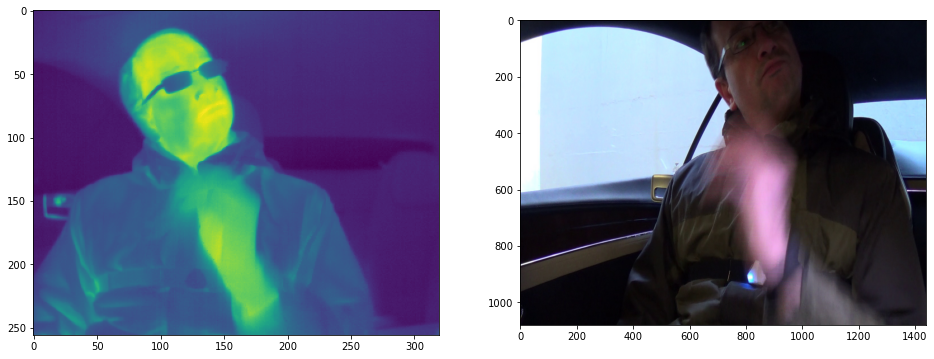

In [11]:
rgb_frame = 50
thr_frame = 1332
thr_rgb_frameplot(p=p, rgb_frame=rgb_frame, thr_frame=thr_frame, oq=False)

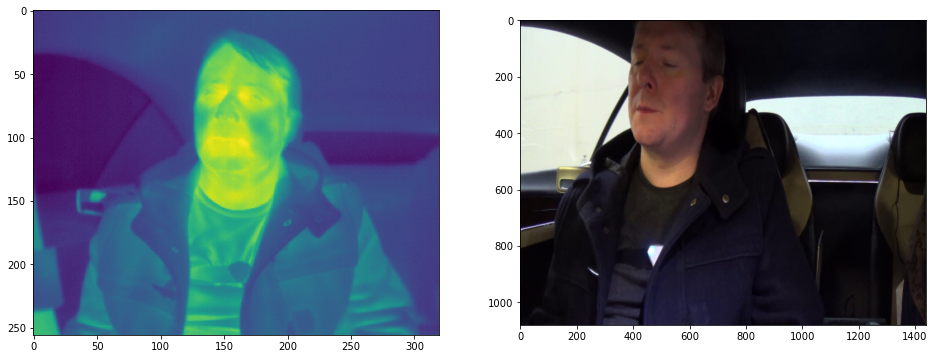

In [12]:
rgb_frame = 17500
thr_frame = 20278
thr_rgb_frameplot(p=p, rgb_frame=rgb_frame, thr_frame=thr_frame, oq=False)

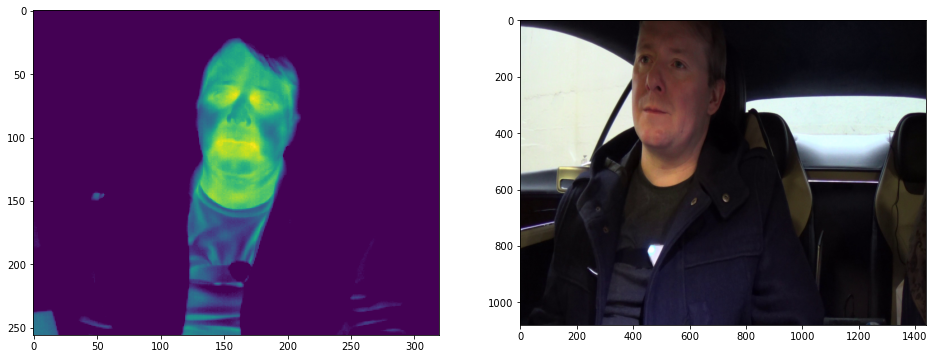

In [14]:
rgb_frame = 17625
thr_frame = 20428
thr_rgb_frameplot(p=p, rgb_frame=rgb_frame, thr_frame=thr_frame, oq=True)

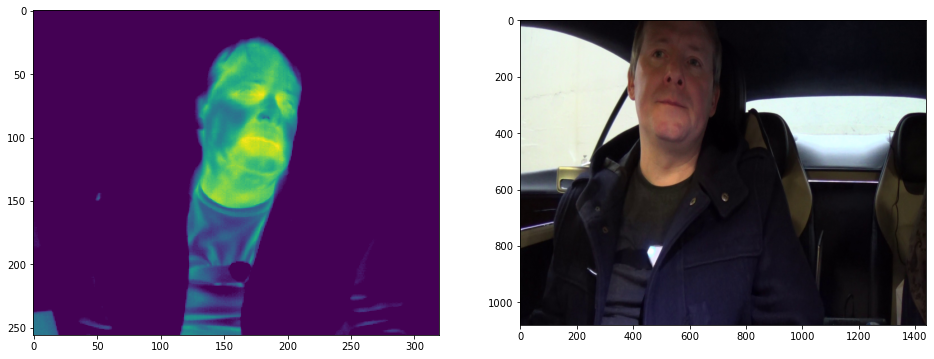

In [13]:
rgb_frame = 17750
thr_frame = 20678
thr_rgb_frameplot(p=p, rgb_frame=rgb_frame, thr_frame=thr_frame, oq=True)

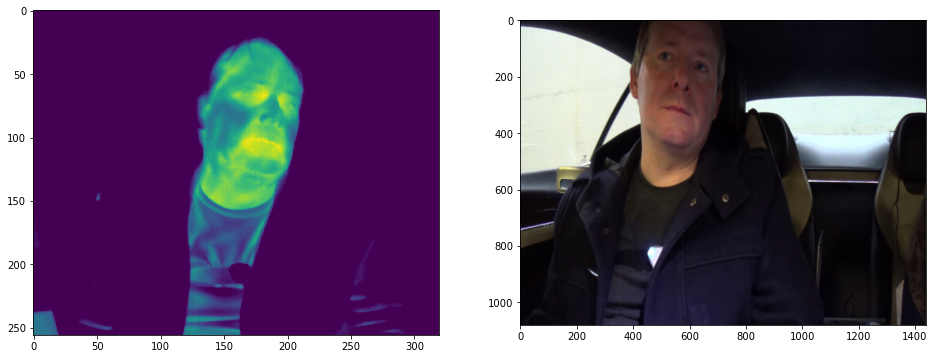

In [15]:
rgb_frame = 17875
thr_frame = 20728
thr_rgb_frameplot(p=p, rgb_frame=rgb_frame, thr_frame=thr_frame, oq=True)

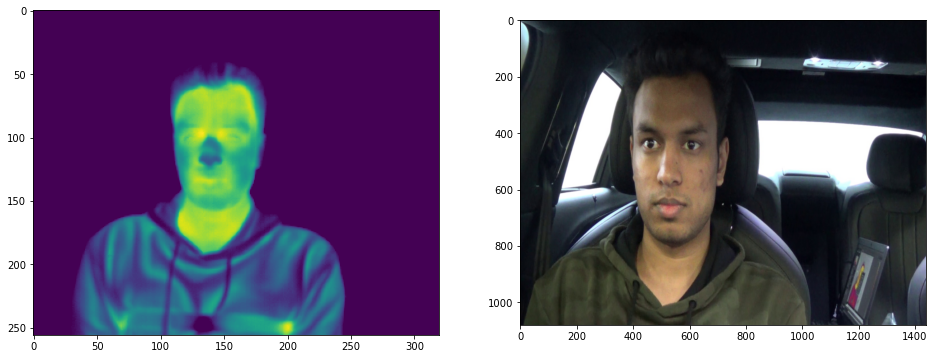

In [83]:
rgb_frame = 8496
thr_frame = 9367
thr_rgb_frameplot(p=p, rgb_frame=rgb_frame, thr_frame=thr_frame, oq=True)

In [422]:
# rgb_frame = 2112
# thr_frame = 2714
# thr_rgb_frameplot_zoom(p=p, rgb_frame=rgb_frame, thr_frame=thr_frame, oq=False)

### Load list of frames frames and check time synch

In [84]:
img_dir = '/Volumes/Ashur DT2/steven/P'+p+'/RGB/00000/'
first_img = 7996
last_img = 8496
interval = 1

start_time = time.time()
rgb_fname_list, rgb_img_list = rgb_load(img_dir=img_dir, first_img=first_img, last_img=last_img, interval=interval)

print("runtime:", time.time() - start_time)

runtime: 39.065515995025635


In [85]:
img_dir = '/Volumes/Ashur DT2/steven/P'+p+'/FLIR_HiRes/npy/'
first_img = 8767
last_img = 9367
interval = 1

start_time = time.time()
thr_fname_list, thr_img_list = thr_load(img_dir=img_dir, first_img=first_img, last_img=last_img, interval=interval)

print("runtime:", time.time() - start_time)

runtime: 3.9514589309692383


### Compare images from selected ranges that should match

In [86]:
def compare_plot(rgb_img_list, thr_img_list, rgb_img_no, thr_img_no):
    fig, ax = plt.subplots(ncols=2, figsize=(16, 12))
    ax[0].imshow(thr_img_list[thr_img_no], cmap=plt.get_cmap('hot'))
    ax[1].imshow(rgb_img_list[rgb_img_no])
#     ax[0].grid()
#     ax[1].grid()
    plt.show()

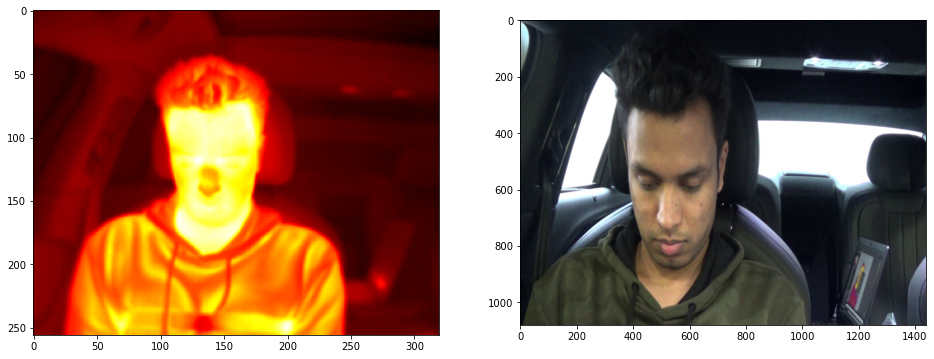

In [87]:
compare_plot(rgb_img_list, thr_img_list, rgb_img_no=0, thr_img_no=0)

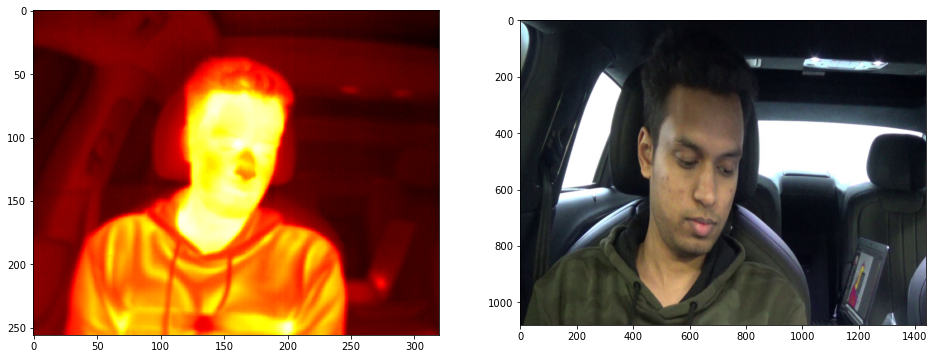

In [88]:
compare_plot(rgb_img_list, thr_img_list, rgb_img_no=250, thr_img_no=300)

## plot export

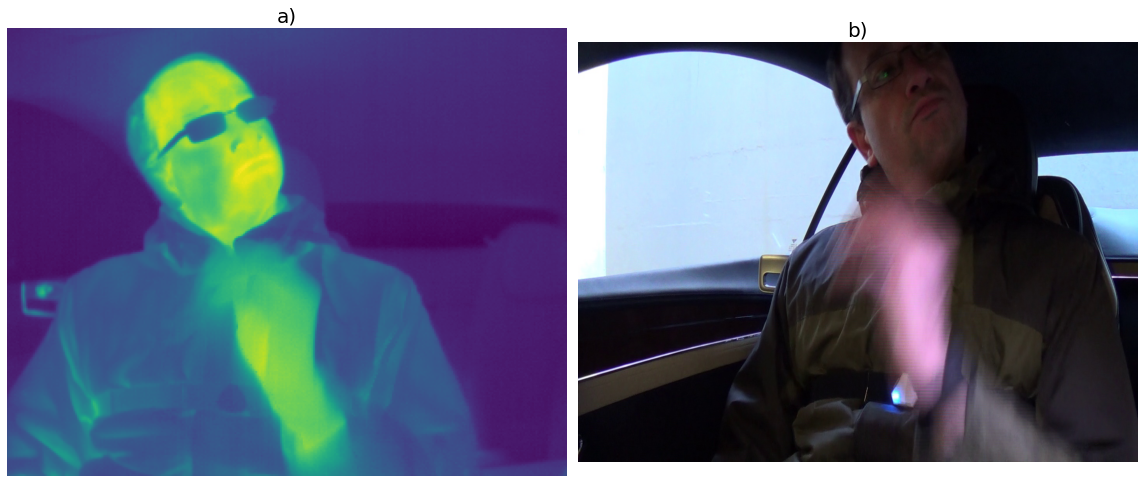

In [15]:
p = '03'
rgb_frame = 50
thr_frame = 1332
thr_rgb_frameplot_export(p=p, rgb_frame=rgb_frame, thr_frame=thr_frame)

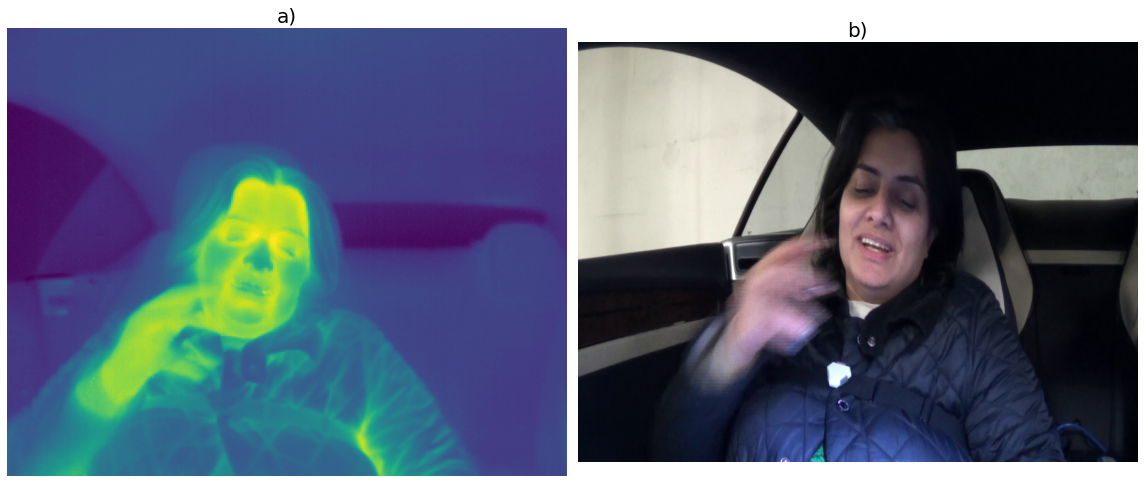

In [16]:
p = '04'
rgb_frame = 11290
thr_frame = 12698
thr_rgb_frameplot_export(p=p, rgb_frame=rgb_frame, thr_frame=thr_frame)

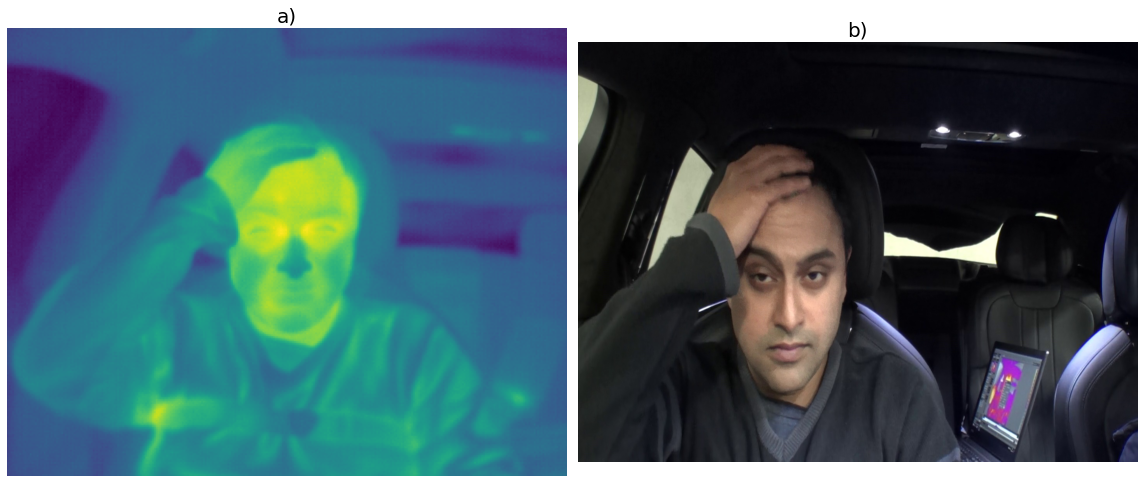

In [17]:
p = '17'
rgb_frame = 2378
thr_frame = 2016
thr_rgb_frameplot_export(p=p, rgb_frame=rgb_frame, thr_frame=thr_frame)

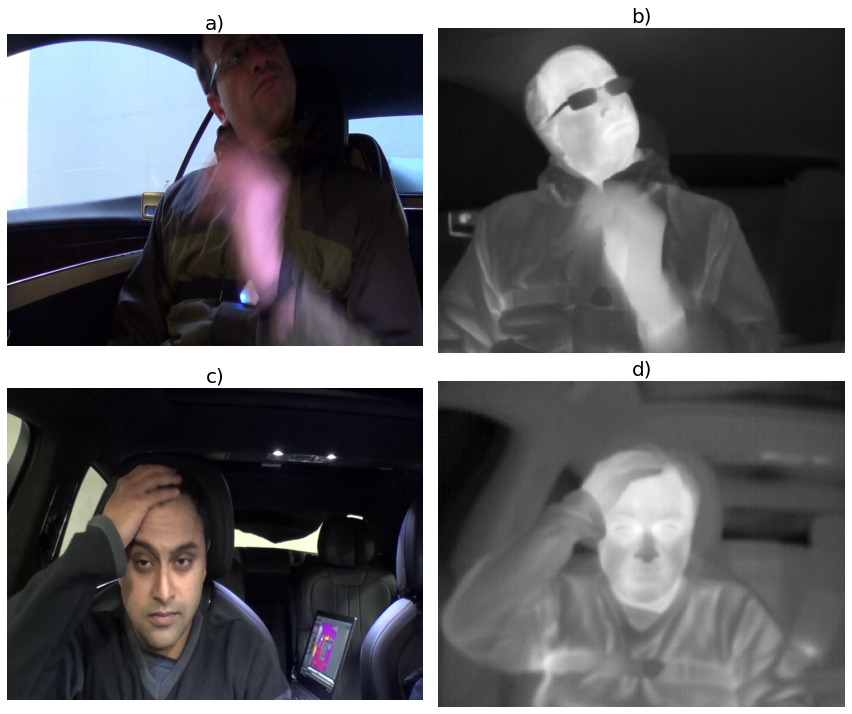

In [23]:
p1 = '03'
rgb_frame1 = 50
thr_frame1 = 1332

p2 = '17'
rgb_frame2 = 2378
thr_frame2 = 2016

"""compare single frames of thermal and rgb"""
rgb_path1 = '/Volumes/Ashur DT2/steven/P' + p1 + '/RGB/00000/00000_' + str(rgb_frame1).zfill(5) + '.jpg'
thr_path1 = '/Volumes/Ashur DT2/steven/P' + p1 + '/FLIR_HiRes/npy/frm_' + str(thr_frame1) + '.npy'


rgb_path2 = '/Volumes/Ashur DT2/steven/P' + p2 + '/RGB/00000/00000_' + str(rgb_frame2).zfill(5) + '.jpg'
thr_path2 = '/Volumes/Ashur DT2/steven/P' + p2 + '/FLIR_HiRes/npy/frm_' + str(thr_frame2) + '.npy'


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

rgb_img1 = dlib.load_rgb_image(rgb_path1)
thr_img1 = np.load(thr_path1)
                       
rgb_img2 = dlib.load_rgb_image(rgb_path2)
thr_img2 = np.load(thr_path2)

ax[0,0].imshow(rgb_img1)
ax[0,1].imshow(thr_img1, cmap='gray')
ax[1,0].imshow(rgb_img2)
ax[1,1].imshow(thr_img2, cmap='gray')

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[1,0].axis('off')
ax[1,1].axis('off')

ax[0,0].set_title("a)", fontsize = 20)
ax[0,1].set_title("b)", fontsize = 20)
ax[1,0].set_title("c)", fontsize = 20)
ax[1,1].set_title("d)", fontsize = 20)

plt.tight_layout()
plot_name = 'timesync_examples.png'
plt.savefig(plot_name)

plt.show()